In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import pickle
import matplotlib.dates as mdates
import matplotlib
import os

In [6]:
#hMinus = 24*2 # Don't use these ones except for testing!
#hPlus = 24*2-1 # Don't use these ones except for testing!
hMinus = 24
hPlus = 24-1
hMinusIQR = 24*5
hPlusIQR = 24*5-1
nDays = 10
# based on Pandas slicing

def add_rolling_dem(df):
    # Can't use np.roll b/c it does not deal with NANs
    # in a sophisticated manner.  Use np.nanmean which
    # skips all NANs and leaves them out of the sum and
    # division
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        val = np.nanmedian(df.loc[i-hMinus:i+hPlus, 'demand (MW)'])
        rolling = np.append(rolling, val)
    
    return df.assign(rollingDem=rolling)


def add_rolling_dem_long(df):
    # Can't use np.roll b/c it does not deal with NANs
    # in a sophisticated manner.  Use np.nanmean which
    # skips all NANs and leaves them out of the sum and
    # division
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        val = np.nanmedian(df.loc[max(0, i-nDays*24):min(i+nDays*24-1, len(df.index)), 'demand (MW)'])
        rolling = np.append(rolling, val)
    
    return df.assign(rollingDemLong=rolling)

def add_demand_minus_rolling_dem(df):
    diff = df['demand (MW)'] - df['rollingDem']
    df = df.assign(dem_minus_rolling=diff)
    return df


def add_demand_rel_diff_wrt_hourly(df):
    diff = df['demand (MW)'] / (df['rollingDem'] * df['hourly_median_dem_dev'])
    df = df.assign(dem_rel_diff_wrt_hourly=diff)
    diff2 = df['demand (MW)'] / (df['rollingDemLong'] * df['hourly_median_dem_dev'])
    df = df.assign(dem_rel_diff_wrt_hourly_long=diff2)
    diff3 = df['dem_rel_diff_wrt_hourly'].diff()
    df = df.assign(dem_rel_diff_wrt_hourly_delta_pre=diff3)
    diff4 = df['dem_rel_diff_wrt_hourly'].diff(periods=-1)
    df = df.assign(dem_rel_diff_wrt_hourly_delta_post=diff4)
    return df


def add_demand_minus_rolling_dem_iqr(df):
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        lst = df.loc[i-hMinusIQR:i+hPlusIQR, 'dem_minus_rolling']
        iqr = np.nanpercentile(lst, 75) - np.nanpercentile(lst, 25)
        rolling = np.append(rolling, iqr)
    
    return df.assign(dem_minus_rolling_IQR=rolling)





def add_hourly_median_dem_deviations(df):
    # Create a df to hold all values to take nanmedian later
    vals_dem_minus_rolling = df['dem_minus_rolling']
    # Loop over nDays days on each side
    for i in range(-nDays, nDays+1):
        # Already initialized with zero value
        if i == 0:
            continue
        vals_dem_minus_rolling = pd.concat(
            [vals_dem_minus_rolling, df.shift(periods=i*24)['dem_minus_rolling']], axis=1)

    df['vals_dem_minus_rolling'] = vals_dem_minus_rolling.median(axis=1, skipna=True)
    # 1+vals to make it a scale factor
    return df.assign(hourly_median_dem_dev=1.+df['vals_dem_minus_rolling']/df['rollingDemLong'])

                
                
# delta with previous and following time steps
def add_deltas(df):
    diff = df['demand (MW)'].diff()
    df = df.assign(delta_pre=diff)
    diff = df['demand (MW)'].diff(periods=-1)
    df = df.assign(delta_post=diff)
    return df



def add_rolling_delta_iqr(df):
    rolling = np.empty((0,), float)
    
    for i in range(len(df.index)):
        lst = df.loc[i-hMinusIQR:i+hPlusIQR, 'delta_pre']
        iqr = np.nanpercentile(lst, 75) - np.nanpercentile(lst, 25)
        rolling = np.append(rolling, iqr)
    
    return df.assign(delta_rolling_IQR=rolling)


def add_categories(df):
    df['category'] = np.where(df['demand (MW)'].isna(), 'MISSING', 'OKAY')
    return df


def filter_neg_and_zeros(df):
    df['category'] = np.where(df['demand (MW)'] <= 0., 'NEG_OR_ZERO', df['category'])
    filtered = np.where(df['demand (MW)'] <= 0., df['demand (MW)'], np.nan)
    df['negAndZeroFiltered'] = filtered
    df['demand (MW)'] = df['demand (MW)'].mask(df['demand (MW)'] <= 0.)
    return df

    
def filter_extrem_demand(df, multiplier):
    med = np.nanmedian(df['demand (MW)'])
    filtered = df['demand (MW)'].where(df['demand (MW)'] < med * multiplier)
    df['globalDemandFiltered'] = np.where(df['demand (MW)'] != filtered, df['demand (MW)'], np.nan)
    df['category'] = df['category'].mask(((df['demand (MW)'] != filtered) & \
                    (df['demand (MW)'].notna())), other='GLOBAL_DEM')
    df['demand (MW)'] = filtered
    return df


def filter_global_plus_minus_one(df):
    globalDemPlusMinusFiltered = [np.nan for _ in df.index]
    for idx in df.index:
        if df.loc[idx, 'category'] == 'GLOBAL_DEM':
            if df.loc[idx-1, 'category'] == 'OKAY':
                df.loc[idx-1, 'category'] = 'GLOBAL_DEM_PLUS_MINUS'
                globalDemPlusMinusFiltered[idx-1] = df.loc[idx-1, 'demand (MW)']
                df.loc[idx-1, 'demand (MW)'] = np.nan
            if df.loc[idx+1, 'category'] == 'OKAY':
                df.loc[idx+1, 'category'] = 'GLOBAL_DEM_PLUS_MINUS'
                globalDemPlusMinusFiltered[idx+1] = df.loc[idx+1, 'demand (MW)']
                df.loc[idx+1, 'demand (MW)'] = np.nan
    df['globalDemPlusMinusFiltered'] = globalDemPlusMinusFiltered
    return df
    

def filter_local_demand(df, multiplier_up, multiplier_down):
    
    # Filter in two steps to provide different labels for the categories
    filtered = df['demand (MW)'].where(
            (df['demand (MW)'] < df['rollingDem'] * df['hourly_median_dem_dev'] + \
                     multiplier_up * df['dem_minus_rolling_IQR']))
    df['localDemandFilteredUp'] = np.where(df['demand (MW)'] != filtered, df['demand (MW)'], np.nan)
    df['category'] = df['category'].mask(((df['demand (MW)'] != filtered) & \
                    (df['demand (MW)'].notna())), other='LOCAL_DEM_UP')
    df['demand (MW)'] = filtered
    
    filtered = df['demand (MW)'].where(
            (df['demand (MW)'] > df['rollingDem'] * df['hourly_median_dem_dev'] - \
                     multiplier_down * df['dem_minus_rolling_IQR']))
    df['localDemandFilteredDown'] = np.where(df['demand (MW)'] != filtered, df['demand (MW)'], np.nan)
    df['category'] = df['category'].mask(((df['demand (MW)'] != filtered) & \
                    (df['demand (MW)'].notna())), other='LOCAL_DEM_DOWN')
    df['demand (MW)'] = filtered
    
    return df


# Filter on a multiplier of the IQR and set
# the associated 'demand (MW)' value to NAN.
# Only consider "double deltas", hours with
# large deltas on both sides
def filter_deltas(df, multiplier):
    
    filtered = df['demand (MW)'].mask(
            ((df['delta_pre'] > df['delta_rolling_IQR'] * multiplier) & \
            (df['delta_post'] > df['delta_rolling_IQR'] * multiplier)) | \
            ((df['delta_pre'] < -1. * df['delta_rolling_IQR'] * multiplier) & \
            (df['delta_post'] < -1. * df['delta_rolling_IQR'] * multiplier)))

    df['deltaFiltered'] = np.where(df['demand (MW)'] != filtered, df['demand (MW)'], np.nan)
    df['category'] = df['category'].mask(((df['demand (MW)'] != filtered) & \
                    (df['demand (MW)'].notna())), other='DELTA')
    df['demand (MW)'] = filtered
    return df


# March through all hours recording previous "good"
# demand value and its index.  Calculate deltas between
# this value and next "good" hour.  If delta is LARGE
# mark NAN.
# Go forwards once, then backwards once to get all options.
def filter_deltas_marching(df, multiplier, rel_multiplier):
    
    # This is a global value, but it is of a relative quantity
    # so should scale as demand expectations change.
    iqr_delta_pre = np.nanpercentile(df['dem_rel_diff_wrt_hourly_delta_pre'], 75) - \
            np.nanpercentile(df['dem_rel_diff_wrt_hourly_delta_pre'], 25)

    # Go through forwards first, then reverse
    prev_good_index = np.nan
    
    deltaSingleFiltered = []
    for idx in df.index:
        deltaSingleFiltered.append(np.nan)
        if np.isnan(df.loc[idx, 'demand (MW)']):
            continue
        
        
        # Initialize first good entry, this will never be flagged
        if np.isnan(prev_good_index):
            prev_good_index = idx
            
        
        # Check deltas demand and relative wrt hourly adjustment
        prev_good_delta_dem = abs(df.loc[prev_good_index, 'demand (MW)'] - df.loc[idx, 'demand (MW)'])
        prev_good_delta_dem_rel_diff_wrt_hourly = abs(df.loc[prev_good_index, 
                        'dem_rel_diff_wrt_hourly'] - df.loc[idx, 'dem_rel_diff_wrt_hourly'])

        
        # delta_rolling_IQR is over 5 days on each side so should be
        # similar regardless of which hours' we use. If delta is
        # large, mark this hour anomalous
        if (prev_good_delta_dem > df.loc[idx, 'delta_rolling_IQR'] * multiplier) and \
                (prev_good_delta_dem_rel_diff_wrt_hourly > rel_multiplier * iqr_delta_pre):
            
            
            # If the previous "good" value was farther from expected values, then consider current hour good
            # and the previous hour will be caught on the way back through the reverse direction.
            # The max deviation from the rolling 4 day dem and the rolling 10 day dem is taken
            # to help catch cases where a large deviation pulls the rolling 4 day dem to center
            # on its values.  i.e. SCL 2016 Dec 15.
            prev_max = max(abs(1. - df.loc[prev_good_index, 'dem_rel_diff_wrt_hourly']),
                            abs(1. - df.loc[prev_good_index, 'dem_rel_diff_wrt_hourly_long']))
            current_max = max(abs(1. - df.loc[idx, 'dem_rel_diff_wrt_hourly']),
                            abs(1. - df.loc[idx, 'dem_rel_diff_wrt_hourly_long']))         
            if abs(current_max) < abs(prev_max):
                prev_good_index = idx
            
            # else, continue to filter this hour
            else:
                deltaSingleFiltered[-1] = df.loc[idx, 'demand (MW)']
                df.loc[idx, 'demand (MW)'] = np.nan
                df.loc[idx, 'category'] = 'SINGLE_DELTA'
        else:
            prev_good_index = idx

    
    df['deltaSingleFilteredFwd'] = deltaSingleFiltered
    
    
    ### Go through reversed, ~ copy of above code ###
    prev_good_index = np.nan
    
    deltaSingleFiltered = []
    for idx in reversed(df.index):
        deltaSingleFiltered.append(np.nan)
        if np.isnan(df.loc[idx, 'demand (MW)']):
            continue
        
        
        # Initialize first good entry, this will never be flagged
        if np.isnan(prev_good_index):
            prev_good_index = idx
            
        
        # Check deltas demand and relative wrt hourly adjustment
        prev_good_delta_dem = abs(df.loc[prev_good_index, 'demand (MW)'] - df.loc[idx, 'demand (MW)'])
        prev_good_delta_dem_rel_diff_wrt_hourly = abs(df.loc[prev_good_index, 
                        'dem_rel_diff_wrt_hourly'] - df.loc[idx, 'dem_rel_diff_wrt_hourly'])

        
        
        # delta_rolling_IQR is over 5 days on each side so should be
        # similar regardless of which hours' we use. If delta is
        # large, mark this hour anomalous
        if (prev_good_delta_dem > df.loc[idx, 'delta_rolling_IQR'] * multiplier) and \
                (prev_good_delta_dem_rel_diff_wrt_hourly > rel_multiplier * iqr_delta_pre):
            
            
            deltaSingleFiltered[-1] = df.loc[idx, 'demand (MW)']
            df.loc[idx, 'demand (MW)'] = np.nan
            df.loc[idx, 'category'] = 'SINGLE_DELTA'
        else:
            prev_good_index = idx

    
    to_app = [val for val in reversed(deltaSingleFiltered)]
    df['deltaSingleFilteredBkw'] = to_app
    
    
    return df

  
            

def filter_runs(df):
    
    d1 = df['demand (MW)'].diff(periods=1)
    d2 = df['demand (MW)'].diff(periods=2)

    # cannot compare a dtyped [float64] array with a scalar of type [bool]
    filtered = df['demand (MW)'].mask((d1 == 0) & (d2 == 0))
    df['runFiltered'] = np.where(df['demand (MW)'] != filtered, df['demand (MW)'], np.nan)
    df['demand (MW)'] = filtered
    df['category'] = np.where(df['runFiltered'].notna(), 'IDENTICAL_RUN', df['category'])
    return df
    

    
def filter_anomalous_regions(df, width, anomalous_pct):
    
    print("filter_anomalous_regions")
    
    percent_good_data_cnt = [0. for _ in df.index]
    percent_good_data_pre = [0. for _ in df.index]
    percent_good_data_post = [0. for _ in df.index]
    df['len_good_data'] = [0 for _ in df.index]
    data_quality_cnt = []
    data_quality_short = []
    start_good_data = np.nan
    end_good_data = np.nan
    for idx in df.index:
            
        # Remove the oldest item in the list
        if len(data_quality_short) > width:
            data_quality_short.pop(0)
        if len(data_quality_cnt) > 2 * width:
            data_quality_cnt.pop(0)
        
        # Add new item and don't count MISSING as 'bad' data
        if df.loc[idx, 'category'] == 'OKAY' or df.loc[idx, 'category'] == 'MISSING':
            data_quality_cnt.append(1)
            data_quality_short.append(1)
            # Track length of good data chunks
            if np.isnan(start_good_data):
                start_good_data = idx
            end_good_data = idx
        else:
            data_quality_cnt.append(0)
            data_quality_short.append(0)
            # Fill in length of good data chunk
            if not (np.isnan(start_good_data) or np.isnan(end_good_data)):
                len_good = end_good_data - start_good_data + 1
                df.loc[start_good_data:end_good_data, 'len_good_data'] = len_good
            start_good_data = np.nan
            end_good_data = np.nan

        
        # centered measurements have length 2 * width
        if len(data_quality_cnt) > 2 * width:
            percent_good_data_cnt[idx-width] = np.mean(data_quality_cnt)
        # left and right / pre and post measurements have length = width + 1
        if len(data_quality_short) > width:
            percent_good_data_pre[idx] = np.mean(data_quality_short)
            percent_good_data_post[idx-width] = np.mean(data_quality_short)



    
    anomalousRegionsFiltered = [np.nan for _ in df.index]
    for idx in df.index:
        if percent_good_data_cnt[idx] <= anomalous_pct:
            for j in range(idx-width, idx+width):
                if j < 1 or j >= len(df.index):
                    continue
                if df.loc[j, 'category'] == 'OKAY':
                    # If this is the start or end of continuous good data, don't filter
                    if percent_good_data_pre[j] == 1.0 or percent_good_data_post[j] == 1.0:
                        continue
                    if df.loc[j, 'len_good_data'] > width:
                        continue
                    df.loc[j, 'category'] = 'ANOMALOUS_REGION'
                    anomalousRegionsFiltered[j] = df.loc[j, 'demand (MW)']
                    df.loc[j, 'demand (MW)'] = np.nan
    

    df['anomalousRegionsFiltered'] = anomalousRegionsFiltered
    return df
    

def mark_missing_and_empty(df, col):
    #marked = np.zeros(len(df.index))
    print(df[col].isna())

def show_structure(df):
    plt.imshow(~df.isna(), aspect='auto')
    plt.xlabel("variables")
    plt.ylabel("cases")
    plt.gray()
    plt.show()


def simple_hist(col, df, iq2, iq3, factor, save, x_log=False):
    plt.close()
    fig, ax = plt.subplots()
    
    if df[col].max() == np.Inf:
        print(save, df[col].max())
        return
    if df[col].min() == np.NINF:
        print(save, df[col].min())
        return
    n, bins, patches = ax.hist(df[col] * (~df['demand (MW)'].isna()), 100, facecolor='red', alpha=0.2, label='pre')
    #n, bins, patches = ax.hist(df['delta_post'], 100, facecolor='blue', alpha=0.2, label='post')
    if col == 'Demand (MW)':
        ax.set_xlabel('Demand (MW)')
    elif col == 'dem_diff_norm_rolling':
        ax.set_xlabel('$\Delta$(Demand, Rolling Avg)/Rolling IQR')
    elif col == 'dem_minus_rolling':
        ax.set_xlabel('$\Delta$(Demand, Rolling Avg) (MW)')
    elif col == 'delta_pre':
        ax.set_xlabel('$\Delta$(Demand ti, Demand ti-1) (MW)')
    elif col == 'delta_pre_norm':
        ax.set_xlabel('Normalized Demand Difference (diff/Rolling IQR)')
    elif col == 'diff_norm_diffIQR_D':
        ax.set_xlabel('Normalized Demand Difference ($\Delta$(t-1, t+1)/Rolling IQR)')
    ax.set_ylabel('Counts')
            
    # Draw iq2 and iq3
    iqr = iq3 - iq2
    iq2_l1 = mlines.Line2D([-iqr,-iqr], ax.get_ylim())
    ax.add_line(iq2_l1)
    iq2_l2 = mlines.Line2D([-iqr*factor,-iqr*factor], ax.get_ylim())
    ax.add_line(iq2_l2)
    iq3_l1 = mlines.Line2D([iqr,iqr], ax.get_ylim())
    ax.add_line(iq3_l1)
    iq3_l2 = mlines.Line2D([iqr*factor,iqr*factor], ax.get_ylim())
    ax.add_line(iq3_l2)
    
    if x_log:
        plt.xscale('log', nonposx='clip')
    plt.tight_layout()
    plt.yscale('log', nonposy='clip')
    plt.savefig(save)
    
    



# Create many demand plots so we can actually see the values
def scrolling_demand(width, region, df, title, save, dem_up, dem_down, delta_up, delta_down, targets=[-1,], plus=0):
    #plus = 0
    #plus = 225
    #plus = 100
    start = 0 + plus
    end = width+plus
    i = 0
    tot_l = len(df.index)
    while True:
        s = save.replace('.pdf', '_{}cnt_{}plus'.format(i, plus))
        # Make names ordered by timeslice if we have target slices
        if targets[0] != -1:
            s = s.replace(region, '{}_{}'.format(i, region))
        t = title+': cnt {}'.format(i)
        o = df.loc[start:end]

        #print("scrolling: start {} - end {}".format(start, end))
        # If requested, only plot certain time frames
        if i not in targets and targets[0] != -1:
            if end == tot_l:
                break
            i += 1
            start += width
            end += width
            if end >= tot_l:
                end = tot_l
            continue
        #comparison_demand_plot(o, t, s, dem_up, dem_down)
        #comparison_diff_plot(o, t, s.replace('cnt', 'cnt_diff'), delta_up, delta_down)
        # end-start+1 is the length, remember pandas slice notation includes end point
        if not (
                (df['globalDemandFiltered'].loc[start:end].isna().sum() == len(o.index)) and \
                (df['localDemandFilteredUp'].loc[start:end].isna().sum() == len(o.index)) and \
                (df['localDemandFilteredDown'].loc[start:end].isna().sum() == len(o.index)) and \
                #(df['runFiltered'].loc[start:end].isna().sum() == len(o.index)) and \
                (df['deltaFiltered'].loc[start:end].isna().sum() == len(o.index)) and \
            
                (df['anomalousRegionsFiltered'].loc[start:end].isna().sum() == len(o.index)) and \
            
                (df['deltaSingleFilteredFwd'].loc[start:end].isna().sum() == len(o.index)) and \
                (df['deltaSingleFilteredBkw'].loc[start:end].isna().sum() == len(o.index)) and \
                (df['negAndZeroFiltered'].loc[start:end].isna().sum() == len(o.index))
               ):
            s = save.replace('.pdf', '_{}cnt_{}plus'.format(i, plus)).replace(region, 'z3_'+region)
            # Make names ordered by timeslice if we have target slices
            if targets[0] != -1:
                s = s.replace(region, '{}_{}'.format(i, region))
            print(start, end, s)
            #comparison_demand_plot(o, t, s, dem_up, dem_down)
            comparison_demand_plot_clean(o, t, s, dem_up, dem_down)
            #comparison_diff_plot(o, t, s.replace('cnt', 'cnt_diff'), delta_up, delta_down)
        if end == tot_l:
            break
        i += 1
        start += width
        end += width
        if end >= tot_l:
            end = tot_l

            

            
def comparison_demand_plot(df, title, save, multiplier_up, multiplier_down):
    plt.close()
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_xlabel('Hour')
    ax.set_ylabel('Demand')
    plt.title(title)
    ax.plot(df['date_time'], df['demand (MW)'], 'kv-', label='demand', linewidth=3.0)
    ax.plot(df['date_time'], df['rollingDemLong'], 'r-.', label='rolling dem long')
    ax.plot(df['date_time'], df['rollingDem'], 'b-', label='rolling dem+/-')
    ax.plot(df['date_time'], df['rollingDem']*df['hourly_median_dem_dev'], 'b--')
    ax.plot(df['date_time'], df['rollingDem']*df['hourly_median_dem_dev']+multiplier_up*df['dem_minus_rolling_IQR'], 'b-.')
    ax.plot(df['date_time'], df['rollingDem']*df['hourly_median_dem_dev']-multiplier_down*df['dem_minus_rolling_IQR'], 'b-.')
    ax.plot(df['date_time'], df['localDemandFilteredUp'], 'mo', label='localDemandFiltered')
    ax.plot(df['date_time'], df['localDemandFilteredDown'], 'mo', label='_nolegend_')
    ax.plot(df['date_time'], df['globalDemandFiltered']*0., 'co', label='globalDemandFiltered')
    ax.plot(df['date_time'], df['globalDemPlusMinusFiltered'], 'co', label='_nolegend_')
    ax.plot(df['date_time'], df['deltaFiltered'], 'go', label='deltaFiltered')
    ax.plot(df['date_time'], df['deltaSingleFilteredFwd'], 'ro', label='deltaSingleFiltered')
    ax.plot(df['date_time'], df['deltaSingleFilteredBkw'], 'rv', label='_nolegend_')
    ax.plot(df['date_time'], df['runFiltered'], 'yo', label='runFiltered')
    ax.plot(df['date_time'], df['anomalousRegionsFiltered'], 'cv', label='anomalousRegionsFiltered')
    plt.legend()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_ylim(min(ax.get_ylim()[0], 0), ax.get_ylim()[1])
    plt.tight_layout()
    plt.grid()
    plt.savefig(save)
    
    
    
    

            

# Shows simplified, clean results     
def comparison_demand_plot_clean(df, title, save, multiplier_up, multiplier_down):
    plt.close()
    fig, ax = plt.subplots(figsize=(15,7))
    matplotlib.rcParams.update({'font.size': 16})
    #ax.set_xlabel('Hour')
    ax.set_ylabel('Demand (MW)')
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.title('')
    
    ax.plot(df['date_time'], df['demand (MW)'], 'k-o', label='Demand', linewidth=3.0)
    #ax.plot(df['date_time'], df['rollingDemLong'], 'r-.', label='rolling dem long')
    #ax.plot(df['date_time'], df['rollingDem'], 'b-', label='rolling dem+/-')
    #ax.plot(df['date_time'], df['rollingDem']*df['hourly_median_dem_dev'], 'b--')
    #ax.plot(df['date_time'], df['rollingDem']*df['hourly_median_dem_dev']+multiplier_up*df['dem_minus_rolling_IQR'], 'b-.')
    #ax.plot(df['date_time'], df['rollingDem']*df['hourly_median_dem_dev']-multiplier_down*df['dem_minus_rolling_IQR'], 'b-.')
    
    s=9
    ax.plot(df['date_time'], df['runFiltered'], 'C0o', label='Identical Run', markersize=s)
    ax.plot(df['date_time'], df['globalDemandFiltered']*0., 'C5o', label='Global Demand', markersize=s)
    ax.plot(df['date_time'], df['globalDemPlusMinusFiltered'], 'C5o', label='_nolegend_', markersize=s)
    ax.plot(df['date_time'], df['deltaFiltered'], 'C2o', label='Double-Sided Delta', markersize=s)
    ax.plot(df['date_time'], df['deltaSingleFilteredFwd'], 'C3o', label='Single-Sided Delta', markersize=s)
    ax.plot(df['date_time'], df['deltaSingleFilteredBkw'], 'C3o', label='_nolegend_', markersize=s)
    ax.plot(df['date_time'], df['localDemandFilteredUp'], 'C4o', label='Local Demand', markersize=s)
    ax.plot(df['date_time'], df['localDemandFilteredDown'], 'C4o', label='_nolegend_', markersize=s)
    ax.plot(df['date_time'], df['negAndZeroFiltered'], 'C6o', label='Negitive or Zero', markersize=s)
    ax.plot(df['date_time'], df['anomalousRegionsFiltered'], 'C1o', label='Anomalous Region', markersize=s)
    


    
    plt.legend(prop={'size': 20}, ncol=3)
    #ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.setp( ax.xaxis.get_majorticklabels(), rotation=45 )
    #ax.xaxis.set_minor_locator(mdates.DayLocator())
    ax.set_ylim(min(ax.get_ylim()[0], 0), ax.get_ylim()[1]*1.5)
    plt.tight_layout()
    plt.grid()
    plt.savefig(save)
    
    
    
    
def comparison_diff_plot(df, title, save, multiplier_up, multiplier_down):
    plt.close()
    fig, ax = plt.subplots(figsize=(15,10))
    ax.set_xlabel('Hour')
    ax.set_ylabel('$\Delta$(Demand ti, ti-1) (MW)')
    plt.title(title)
    ax.plot(df['date_time'], df['delta_pre'], 'k-', label='delta_pre')
    ax.plot(df['date_time'], multiplier_up*df['delta_rolling_IQR'], 'b-.')
    ax.plot(df['date_time'], -multiplier_down*df['delta_rolling_IQR'], 'b-.')
    plt.legend()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.DayLocator())
    plt.tight_layout()
    plt.grid()
    plt.savefig(save)

    
    
def get_iqrs(vals):
    iq3 = np.nanpercentile(vals, 75)
    iq2 = np.nanpercentile(vals, 25)
    iqr = iq3 - iq2
    return iqr, iq2, iq3


def return_all_regions():
    return ['AEC', 'AECI', 'CPLE', 'CPLW',
    'DUK', 'FMPP', 'FPC',
    'FPL', 'GVL', 'HST', 'ISNE',
    'JEA', 'LGEE', 'MISO', 'NSB',
    'NYIS', 'OVEC', 'PJM', 'SC',
    'SCEG', 'SEC', 'SOCO',
    'SPA', 'SWPP', 'TAL', 'TEC',
    'TVA', 'ERCO',
    'AVA', 'AZPS', 'BANC', 'BPAT',
    'CHPD', 'CISO', 'DOPD',
    'EPE', 'GCPD', 'IID',
    'IPCO', 'LDWP', 'NEVP', 'NWMT',
    'PACE', 'PACW', 'PGE', 'PNM',
    'PSCO', 'PSEI', 'SCL', 'SRP',
    'TEPC', 'TIDC', 'TPWR', 'WACM',
    'WALC', 'WAUW']

def plot_var_by_time(df, region, var, include_dem=True):
    print("Plotting reg {} var {}".format(region, var))
    plt.close()
    fig, ax = plt.subplots(figsize=(15,5))
    if include_dem:
        ax.plot(df['date_time'], df['demand (MW)'], 'k-', label='Demand')
    ax.plot(df['date_time'], df[var], 'r-', label=var)
    plt.tight_layout()
    plt.legend()
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    plt.title("{} {}".format(region, var))
    plt.savefig('plt/{}_{}.pdf'.format(region, var))

IID
Saving pickle /Users/truggles/tmp_dataOct15/pickle_IID_v12_2day.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_IID_v12_2day.pkl
filter_anomalous_regions
Saving pickle /Users/truggles/tmp_dataOct15/pickle_IID_v12_2day_r2.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_IID_v12_2day_r2.pkl
21560 21800 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_89cnt_200plus


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


21800 22040 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_90cnt_200plus
22520 22760 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_93cnt_200plus
22760 23000 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_94cnt_200plus
23000 23240 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_95cnt_200plus
23240 23480 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_96cnt_200plus
25880 26120 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_107cnt_200plus
29960 30200 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_124cnt_200plus
31160 31400 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_129cnt_200plus
31400 31640 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_130cnt_200plus
34760 35000 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_IID_demand_show_filters_144cnt_200

/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1371: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input, interpolation=interpolation


Saving pickle /Users/truggles/tmp_dataOct15/pickle_NSB_v12_2day.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_NSB_v12_2day.pkl
filter_anomalous_regions
Saving pickle /Users/truggles/tmp_dataOct15/pickle_NSB_v12_2day_r2.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_NSB_v12_2day_r2.pkl
6440 6680 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_26cnt_200plus
9080 9320 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_37cnt_200plus
10040 10280 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_41cnt_200plus
11000 11240 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_45cnt_200plus
13880 14120 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_57cnt_200plus
16760 17000 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_69cnt_200plus
17000 17240 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_NSB_demand_show_filters_70c

33560 33800 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_139cnt_200plus
33800 34040 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_140cnt_200plus
34040 34280 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_141cnt_200plus
34280 34520 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_142cnt_200plus
34520 34760 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_143cnt_200plus
34760 35000 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_144cnt_200plus
35720 35960 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_148cnt_200plus
36440 36547 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SOCO_demand_show_filters_151cnt_200plus
SPA
Saving pickle /Users/truggles/tmp_dataOct15/pickle_SPA_v12_2day.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_SPA_v12_2day.pkl
filter_anomalous_regions
Saving pickle

filter_anomalous_regions
Saving pickle /Users/truggles/tmp_dataOct15/pickle_SWPP_v12_2day_r2.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_SWPP_v12_2day_r2.pkl
23960 24200 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SWPP_demand_show_filters_99cnt_200plus
25640 25880 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SWPP_demand_show_filters_106cnt_200plus
32840 33080 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SWPP_demand_show_filters_136cnt_200plus
34760 35000 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_SWPP_demand_show_filters_144cnt_200plus
WALC
Saving pickle /Users/truggles/tmp_dataOct15/pickle_WALC_v12_2day.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_WALC_v12_2day.pkl
filter_anomalous_regions
Saving pickle /Users/truggles/tmp_dataOct15/pickle_WALC_v12_2day_r2.pkl
Loading from pickle /Users/truggles/tmp_dataOct15/pickle_WALC_v12_2day_r2.pkl
200 440 /Users/truggles/tmp_plots_v12_2day_Oct15_Feb20/z3_WALC_demand_show_filters_0cnt_200plu

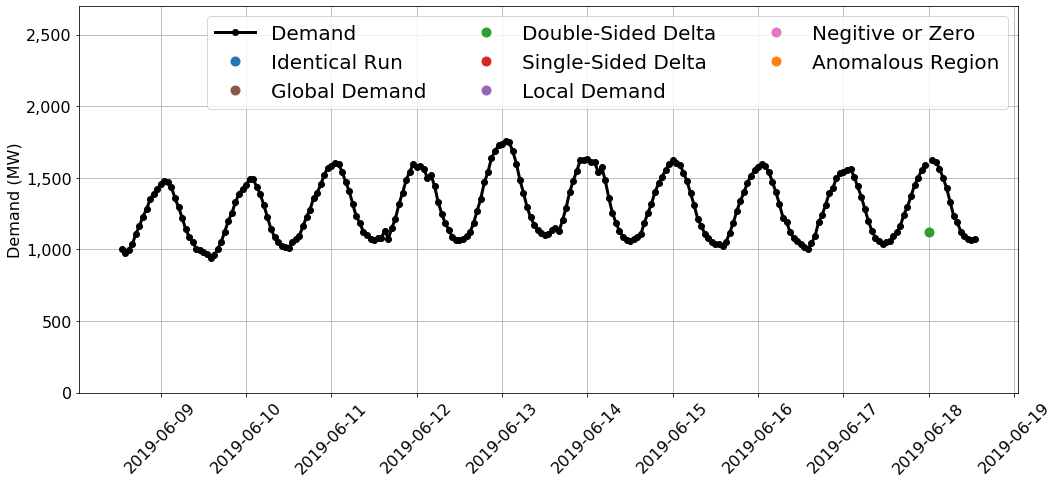

In [7]:
global_dem_cut = 10
local_dem_cut_up = 3.5
local_dem_cut_down = 2.5
delta_multiplier = 2
delta_single_multiplier = 5
rel_multiplier = 15
anomalous_regions_width = 24
anomalous_pct = .85


dump_to_pickle = True
second_filter_and_save = True
load_from_pickle = True
version = '_v12_2day'

app = 'Oct15'
ext = 'Feb20'

png_path = '/Users/truggles/tmp_plots{}_{}_{}/'.format(version, app, ext)
if not os.path.isdir(png_path): os.mkdir(png_path)
data_path = f'/Users/truggles/tmp_data{ext}/'
if not os.path.isdir(data_path): os.mkdir(data_path)

regions = return_all_regions()




regions = ['WALC','SPA', 'SWPP', 'NSB', 'SOCO', 'SCL', 'NWMT', 'IID']

regions.sort()
for region in regions:
    print(region)

    dem_map = {}
    if dump_to_pickle:
        file_path = '/Users/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data/data/release_2019_Oct/original_eia_files/{}.csv'.format(region)
        dem_map[region] = pd.read_csv(file_path,
                           dtype={'demand (MW)':np.float64},
                          parse_dates=True, na_values=['MISSING', 'EMPTY'])
        
        # This is only for checking REGIONS and CONUS after aggregating imputed data
        #dem_map[region]['demand (MW)'] = dem_map[region]['cleaned demand (MW)']
        
        # Convert date/time
        dem_map[region]['date_time'] = pd.to_datetime(dem_map[region]['date_time'])

        
        # Drop unused columns
        dem_map[region] = dem_map[region].drop(['forecast demand (MW)',], axis=1)

        # Add categories to track filtering
        dem_map[region] = add_categories(dem_map[region])
        
        # Missing and empty values are marked
        dem_map[region] = dem_map[region].assign(missing=dem_map[region]['demand (MW)'].isna())

        # Set all negative and zero values to NAN
        dem_map[region] = filter_neg_and_zeros(dem_map[region])
        
        # Set last demand values in runs of 3+ to NAN
        dem_map[region] = filter_runs(dem_map[region])

        # Global demand filter on 10x the median value
        dem_map[region] = filter_extrem_demand(dem_map[region], global_dem_cut)
        
        # Filter +/- 1 hour from any global deman filtered hours
        dem_map[region] = filter_global_plus_minus_one(dem_map[region])
        

        # Add rolling dem average
        dem_map[region] = add_rolling_dem(dem_map[region])
        dem_map[region] = add_rolling_dem_long(dem_map[region])
        dem_map[region] = add_demand_minus_rolling_dem(dem_map[region])
        dem_map[region] = add_hourly_median_dem_deviations(dem_map[region])
        dem_map[region] = add_demand_minus_rolling_dem_iqr(dem_map[region])
        
        

        # Add deltas
        dem_map[region] = add_deltas(dem_map[region])
        dem_map[region] = add_rolling_delta_iqr(dem_map[region])
   
        dem_map[region] = add_demand_rel_diff_wrt_hourly(dem_map[region])


        
        print('Saving pickle /Users/truggles/tmp_data{}/pickle_{}{}.pkl'.format(app, region, version))
        pickle_file = open('/Users/truggles/tmp_data{}/pickle_{}{}.pkl'.format(app, region, version), 'wb') 
        pickle.dump(dem_map[region], pickle_file)
        pickle_file.close()
        #dem_map[region].to_csv('/Users/truggles/tmp_data2/csv_{}.csv'.format(region))
        #continue

        
    if second_filter_and_save:
        print('Loading from pickle /Users/truggles/tmp_data{}/pickle_{}{}.pkl'.format(app, region, version))
        pickle_in = open('/Users/truggles/tmp_data{}/pickle_{}{}.pkl'.format(app, region, version),'rb')
        dem_map[region] = pickle.load(pickle_in)
        dem_map[region]['date_time'] = pd.to_datetime(dem_map[region]['date_time'])
        
        dem_map[region] = filter_local_demand(dem_map[region], local_dem_cut_up, local_dem_cut_down)
        dem_map[region] = filter_deltas(dem_map[region], delta_multiplier)

        dem_map[region] = filter_deltas_marching(dem_map[region], delta_single_multiplier, rel_multiplier)
        
        dem_map[region] = filter_anomalous_regions(dem_map[region], anomalous_regions_width, anomalous_pct)
        
        print('Saving pickle /Users/truggles/tmp_data{}/pickle_{}{}_r2.pkl'.format(app, region, version))
        pickle_file = open('/Users/truggles/tmp_data{}/pickle_{}{}_r2.pkl'.format(app, region, version), 'wb') 
        pickle.dump(dem_map[region], pickle_file)
        pickle_file.close()
        dem_map[region].to_csv('/Users/truggles/tmp_dataOct7/csv_{}.csv'.format(region))
        #continue
        
        
        
    if load_from_pickle:
        print('Loading from pickle /Users/truggles/tmp_data{}/pickle_{}{}_r2.pkl'.format(app, region, version))
        pickle_in = open('/Users/truggles/tmp_data{}/pickle_{}{}_r2.pkl'.format(app, region, version),'rb')
        dem_map[region] = pickle.load(pickle_in)
        dem_map[region]['date_time'] = pd.to_datetime(dem_map[region]['date_time'])
        
    
    
    
    width = 240
    title = '{} Demand Showing Filters'.format(region)
    
    save = '{}{}_demand_show_filters.pdf'.format(png_path, region)

    targets = [95, 96, 101, 27]
    targets = [-1,]
    plus = 200
    scrolling_demand(width, region, dem_map[region], title, save, local_dem_cut_up, local_dem_cut_down,
                    delta_multiplier, delta_multiplier, targets, plus)



In [ ]:
prep_final_output = True
version = '_v12_2day'
version = '_v12_2day_VandV_Jan22'
print("prep_final_output {}".format(prep_final_output))

regions = return_all_regions()




regions.sort()
print(regions)
for i, region in enumerate(regions):
    if not prep_final_output:
        break
    if region in ['SEC', 'OVEC']:
        print("REGION SKIPPED")
        continue
    print('Loading from pickle /Users/truggles/tmp_dataJan22/pickle_{}{}_r2.pkl'.format(region, version))
    pickle_in = open('/Users/truggles/tmp_dataJan22/pickle_{}{}_r2.pkl'.format(region, version),'rb')
    if i == 0: # Load first instance to master
        master = pickle.load(pickle_in)
        master['date_time'] = pd.to_datetime(master['date_time'])
        master[region] = master['demand (MW)']
        master[region+'_category'] = master['category']
        master = master.drop(['demand (MW)', 'category', 'missing', 'runFiltered', 
                              'globalDemandFiltered', 'globalDemPlusMinusFiltered', 'negAndZeroFiltered',
                              'rollingDem', 'deltaFiltered',
                              'deltaSingleFilteredFwd', 'deltaSingleFilteredBkw',
                              'rollingDemLong', 'dem_minus_rolling', 
                              'vals_dem_minus_rolling', 'localDemandFilteredUp', 'localDemandFilteredDown',
                              'hourly_median_dem_dev', 'dem_minus_rolling_IQR',
                              'delta_pre', 'delta_post', 'delta_rolling_IQR',
                              'dem_rel_diff_wrt_hourly_delta_post',
                              'dem_rel_diff_wrt_hourly_delta_pre',
                              'dem_rel_diff_wrt_hourly_long', 'dem_rel_diff_wrt_hourly',
                              'len_good_data', 'anomalousRegionsFiltered'
                             ], axis=1)
        continue
        

    df = pickle.load(pickle_in)
    master[region] = df['demand (MW)']
    master[region+'_category'] = df['category']

if prep_final_output:
    print(master.head(5))
    master.to_csv('/Users/truggles/tmp_dataJan22/csv_MASTER_XXX{}.csv'.format(version), index=False, na_rep='NA')
        

In [ ]:

### THIS IS FOR CHECKING IF IMPUTATIONS PASS THE ORIGINAL SELECTIONS ###

do_check = True
if not do_check:
    assert(2+2==5)


global_dem_cut = 10
local_dem_cut_up = 3.5
local_dem_cut_down = 2.5
delta_multiplier = 2
delta_single_multiplier = 5
rel_multiplier = 15
anomalous_regions_width = 24
anomalous_pct = .85



dump_to_pickle = False
second_filter_and_save = False
load_from_pickle = True
version = '_v12_2day_VandV_Jan22'
old_version = '_v12_2day'


regions = return_all_regions()
regions.sort()



master_file = pd.read_csv('~/Downloads/overimpute_Jan_2020_All_Files/mean_impute_csv_MASTER_v12_2day_mice_Jan16.csv')
master_file['date_time'] = pd.to_datetime(master_file['date_time'])

#regions = ['FPC','JEA','WALC','SPA','NWMT','IID']

for region in regions:
    print(region)
    if region in ['SEC', 'OVEC']:
        print("REGION SKIPPED")
        continue

        
    ### Grab the ORIGINAL version of this file
    #
    #   This allows us to get the original IQR thresholds
    #   for comparing deltas most accurately
    #
    ###
    file_path = '/Users/truggles/tmp_dataOct15/pickle_{}{}_r2.pkl'.format(region, old_version)
    print('Loading ORIGINAL pickle {}'.format(file_path))
    pickle_in = open(file_path,'rb')
    old_df = pickle.load(pickle_in)
    old_df = old_df.drop([i for i in range(19)])
    old_df = old_df.drop([i for i in range(35064+19,36547)])
    old_df = old_df.reset_index()
    #print(old_df.head())
    #print(old_df.tail())
        
        
        
    dem_map = {}
    if dump_to_pickle:
        dem_map[region] = master_file[['date_time', region]].copy()
        dem_map[region]['demand (MW)'] = dem_map[region][region]
        #print(dem_map[region].head())
        #print(dem_map[region].tail())
        
        # Add categories to track filtering
        dem_map[region] = add_categories(dem_map[region])
        
        # Missing and empty values are marked
        dem_map[region] = dem_map[region].assign(missing=dem_map[region]['demand (MW)'].isna())

        # Set all negative and zero values to NAN
        dem_map[region] = filter_neg_and_zeros(dem_map[region])
        
        # Set last demand values in runs of 3+ to NAN
        dem_map[region] = filter_runs(dem_map[region])

        # Global demand filter on 10x the median value
        dem_map[region] = filter_extrem_demand(dem_map[region], global_dem_cut)
        
        # Filter +/- 1 hour from any global deman filtered hours
        dem_map[region] = filter_global_plus_minus_one(dem_map[region])
        

        # Add rolling dem average
        dem_map[region] = add_rolling_dem(dem_map[region])
        dem_map[region] = add_rolling_dem_long(dem_map[region])
        dem_map[region] = add_demand_minus_rolling_dem(dem_map[region])
        dem_map[region] = add_hourly_median_dem_deviations(dem_map[region])
        dem_map[region] = add_demand_minus_rolling_dem_iqr(dem_map[region])
        #FIXME??? dem_map[region]['dem_minus_rolling_IQR'] = old_df['dem_minus_rolling_IQR']
        

        # Add deltas
        dem_map[region] = add_deltas(dem_map[region])
        dem_map[region] = add_rolling_delta_iqr(dem_map[region])
        #old_df = add_deltas(old_df)
        #old_df = add_rolling_delta_iqr(old_df)
        dem_map[region]['delta_rolling_IQR'] = np.where(
            ((old_df['delta_rolling_IQR'] < dem_map[region]['delta_rolling_IQR']) | \
            old_df['delta_rolling_IQR'].isna()), dem_map[region]['delta_rolling_IQR'],
            old_df['delta_rolling_IQR'])
    

        #dem_map[region] = filter_local_demand(dem_map[region], local_dem_cut_up, local_dem_cut_down)
        #dem_map[region] = filter_deltas(dem_map[region], delta_multiplier)
        
        print('Saving pickle /Users/truggles/tmp_dataJan22/pickle_{}{}.pkl'.format(region, version))
        pickle_file = open('/Users/truggles/tmp_dataJan22/pickle_{}{}.pkl'.format(region, version), 'wb') 
        pickle.dump(dem_map[region], pickle_file)
        pickle_file.close()
        #dem_map[region].to_csv('/Users/truggles/tmp_data2/csv_{}.csv'.format(region))
        #continue

        
    if second_filter_and_save:
        print('Loading from pickle /Users/truggles/tmp_dataJan22/pickle_{}{}.pkl'.format(region, version))
        pickle_in = open('/Users/truggles/tmp_dataJan22/pickle_{}{}.pkl'.format(region, version),'rb')
        dem_map[region] = pickle.load(pickle_in)
        dem_map[region]['date_time'] = pd.to_datetime(dem_map[region]['date_time'])
        
        dem_map[region] = filter_local_demand(dem_map[region], local_dem_cut_up, local_dem_cut_down)
        dem_map[region] = filter_deltas(dem_map[region], delta_multiplier)
        dem_map[region] = add_demand_rel_diff_wrt_hourly(dem_map[region])
        dem_map[region] = filter_deltas_marching(dem_map[region], delta_single_multiplier, rel_multiplier)
        
        dem_map[region] = filter_anomalous_regions(dem_map[region], anomalous_regions_width, anomalous_pct)
        
        print('Saving pickle /Users/truggles/tmp_dataJan22/pickle_{}{}_r2.pkl'.format(region, version))
        pickle_file = open('/Users/truggles/tmp_dataJan22/pickle_{}{}_r2.pkl'.format(region, version), 'wb') 
        pickle.dump(dem_map[region], pickle_file)
        pickle_file.close()
        #dem_map[region].to_csv('/Users/truggles/tmp_data4/csv_{}.csv'.format(region))
        #continue
        
        
        
    if load_from_pickle:
        print('Loading from pickle /Users/truggles/tmp_dataJan22/pickle_{}{}_r2.pkl'.format(region, version))
        pickle_in = open('/Users/truggles/tmp_dataJan22/pickle_{}{}_r2.pkl'.format(region, version),'rb')
        dem_map[region] = pickle.load(pickle_in)
        dem_map[region]['date_time'] = pd.to_datetime(dem_map[region]['date_time'])
        
    
    
    
    
    
    
    width = 240
    title = '{} Demand Showing Filters'.format(region)
    save = '/Users/truggles/tmp_plots{}xxxJan22/{}_demand_show_filters.png'.format(version, region)

    targets = [95, 96, 101, 27]
    targets = [-1,]
    plus = 200-19
    scrolling_demand(width, region, dem_map[region], title, save, local_dem_cut_up, local_dem_cut_down,
                    delta_multiplier, delta_multiplier, targets, plus)



In [ ]:
regions = ['CONUS_from_BAs_for_MEM', 'EASTERN_from_BAs_for_MEM', 
           'TEXAS_from_BAs_for_MEM', 'WESTERN_from_BAs_for_MEM']
dfs = {}
for r in regions:
    dfs[r] = pd.read_csv('~/data5_out/{}.csv'.format(r))

for r in regions:
    print(r)
    print(dfs[r].head())
    print(dfs[r].isna().sum())

print((dfs['CONUS_from_BAs_for_MEM']['demand (MW)'] == dfs['EASTERN_from_BAs_for_MEM']['demand (MW)'] + \
           dfs['TEXAS_from_BAs_for_MEM']['demand (MW)'] + dfs['WESTERN_from_BAs_for_MEM']['demand (MW)']).sum())
print(len(dfs['CONUS_from_BAs_for_MEM'].index))